# <center>CMPBIO210, IB120, IB201
# <center>"Introduction to Quantitative Methods in Biology"
# <center>Lecture 3. Numerical Methods of Solving ODEs
## <center>Denis Titov

**The goal of this jupyter notebook is to introduce you to how numerical methods for solution of ordinary differential equations (ODEs) work in general and review various option of SciPy solve_ivp() function. This is a math heavy subject but it's good to have a basic idea of how ODE solvers like solve_ivp() actually work if you plan to use them.**

In [ ]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Example: Clearance of drugs from the blood

We will use drug clearance from the blood through kidney filtration as an example in this section.
Drug clearance from the blood can be describe using differential equation $\frac{d[Drug](t)}{dt}=-k[Drug](t)$, where $t$ is time,  k is some constant describing kindey filtration rate,  $[Drug](t)$ is blood concentration of drug at time $t$ and $[Drug]_0$ is is blood concentration of drug at $t=0$. 

# Numerical solution of $\frac{d[Drug]}{dt}=-k[Drug]$

#### We can solve $\frac{d[Drug](t)}{dt}=-k[Drug](t)$ numerically using solve_ivp() from SciPy library.

In [ ]:
k = 1
Drug_0 = [1]
tspan = [0, 5]

def fun(t, y):
    dDrug_dt = -k * y
    return dDrug_dt

soln = solve_ivp(fun, tspan, Drug_0, t_eval=np.linspace(0, 5, 1000))

plt.plot(soln.t, soln.y[0], label="solve_ivp() solution")
plt.legend();

Now, let's write code to solve $\frac{d[Drug]}{dt}=-k[Drug]$ without using solve_ivp() function with the goal of better understanding how solve_ivp() and similar methods actually works.

### Euler method

The basic idea behind numerical methods for solving ODEs is to simply take some small number for $\Delta t$ and do repetitive algebraic calculation with it.  
For example, let't take some value of $\Delta t$ and find a solution for $\frac{d[Drug](t)}{dt}=-k[Drug](t)$ starting from initial $[Drug]_0$  
  
First, we rewrite $\frac{d[Drug](t)}{dt}=-k[Drug](t)$ as $\frac{\Delta[Drug]}{\Delta t}=\frac{[Drug]_{t+\Delta t}-[Drug]_{t}}{\Delta t}=-k[Drug]_{t}$.  
  
Next, we can use our initial condition $[Drug]_{t=0}=[Drug]_0$ to find $[Drug]_{\Delta t}$:  
  
$[Drug]_{\Delta t}=[Drug]_0-\Delta t \cdot k \cdot [Drug]_0=[Drug]_0 \cdot (1-\Delta t \cdot k)$  
  
Repeat the same to get $[Drug]_{2 \cdot \Delta t}$, $[Drug]_{3 \cdot \Delta t}$ ... etc:  
  
$[Drug]_{2 \cdot \Delta t}=[Drug]_{\Delta t}-\Delta t \cdot k \cdot [Drug]_{\Delta t}=[Drug]_0 \cdot (1-\Delta t \cdot k)^2$  
  
$[Drug]_{3 \cdot \Delta t}=[Drug]_0 \cdot (1-\Delta t \cdot k)^3$... etc etc etc for as many $\Delta t$ steps as we want.   
  
This is called the explicit Euler method and is the simplest method that can be used to numerically solve ODEs although it is rarely used in practice as there are more efficient methods as we will review below.  

### Let's implement Euler method with python code.

#### For loops

We will need to use a *for loop* to implement Euler method.  
*For loops* are very common in computer programs and is a way to make computer do a repetitive task like Euler method.  
Here's a simple example of a *for loop*:

In [ ]:
for i in range(5):
    print(i)

Note that numbering in python starts at 0 as opposed to 1 and that last number (i.e. 5 above) is not included.  
*Side note: this is a major point of contention betweem programming languages with more math/science focused languages having 1-based indexing (e.g, Fortran, Julia, Matlab, R) while other languages made a poor choice of having 0 based indexing which is in my humble opinion nonsensical! (e.g., C, Python, Java)*

#### Euler method code

In [ ]:
dt = 0.5
k = 1

Drug = np.array([1,])
time = np.array([0,])
for t in range(1, round(11)):
    Drug = np.append(Drug, Drug[t - 1] - dt * k * Drug[t - 1])
    time = np.append(time, time[t - 1] + dt)

plt.plot(time, Drug, label='Euler')
plt.legend();

Note that you have to choose $\Delta t$ carefully as $\Delta t$>2 will produce an unstable solution because if $|1-\Delta t \cdot k|>1$ than numerical solution will go to $\infty$ if number of steps goes to $\infty$.  

#### $\frac{d[Drug]}{dt}=-k[Drug]$ is simple enough so that we can also solve it analytically using dsolve() function from SymPy library:

In [ ]:
Drug = sym.symbols("[Drug]", cls=sym.Function)
t, k, Drug_0 = sym.symbols("t, k, [Drug]_0")
sym.dsolve(sym.diff(Drug(t), t) + k * Drug(t), Drug(t), ics={Drug(0): Drug_0})

#### Let's compare Euler method with analytical solution and solve_ivp() solution

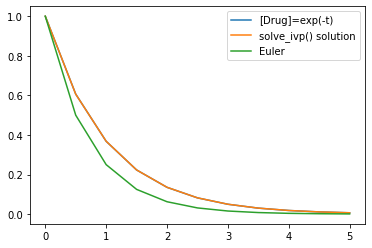

In [44]:
dt = 0.5
k = 1

Drug = np.array([1,])
time = np.array([0,])
for t in range(1, round(5/dt)+1):
    Drug = np.append(Drug, Drug[t - 1] - dt * k * Drug[t - 1])
    time = np.append(time, time[t - 1] + dt)

Drug_0 = [1]
tspan = [0, 5]

def fun(t, y):
    dDrug_dt = -k * y
    return dDrug_dt

soln = solve_ivp(fun, tspan, Drug_0, t_eval=np.linspace(0, 5, round(5/dt)+1))
plt.plot(time, np.exp(-k*time), label='[Drug]=exp(-t)')
plt.plot(soln.t, soln.y[0], label="solve_ivp() solution")
plt.plot(time, Drug, label='Euler')
plt.legend();

Curves for solve_ivp() and analytical solution are indistinguishable above and Euler at very low $\Delta t$ also merges with them

### What is the advantage of inventing other numerical method if Euler works?
There're hundreds of numerical methods that people have invented.  
Numerical methods have to balance numerical accuracy vs computational speed.  
Euler method will be 10x more accurate if you decrease $\Delta t$ 10x but it will also take 10x longer for computer to calculate a solution because it'll have to take 10x more steps. Because of this tradeoff between speed and accuracy, people have spent lots of time inventing new methods that can be as accurate as Euler while taking much larger steps or much faster than Euler with the same accuracy.  More modern methods are orders of magnitude better than Euler as we'll se below.

### Source of errors in Euler and other numerical methods

All numerical methods are approximations of the analytical solution and the error of numerical methods is the difference between numerical solution and analytical solution.  
  
  Let's analyze the error introduced by Euler method above and find how error depends on $\Delta t$.

**Derivative overview**  
In order to understand the stuff below we need to remember about derivatives and diffrentials.  
  You've likely learned a bunch of rules of how to calculate differentials of different function like $y(t)=t^2$ or $y(t)=\frac{1}{t^2}$.  
  
Let's manually calculate a differential of $y(t)=t^2$ to further demystify differentials:

$\frac{dy(t)}{dt}=\lim_{\Delta t \to 0} \frac{y(t+\Delta t)-y(t)}{\Delta t}$  
  
  $\frac{y(t+\Delta t)-y(t)}{\Delta t}=\frac{(t+\Delta t)^2-t^2}{\Delta t}=\frac{t^2+2t \cdot \Delta t + \Delta t^2-t^2}{\Delta t}=2t + \Delta t$  
  
  Since $\Delta t \to 0$, we get $\frac{dy(t)}{dt}=2t$

**Taylor Series overview**  
One way to analyze the magnitude of error introduced by Euler method is by using Taylor series.  
You likely learned about Taylor series in intro calculus: https://en.wikipedia.org/wiki/Taylor_series.   
  
  Taylor series is the following equation and is key for many numerical ODE methods:  
  
  $y(t+\Delta t)=y(t)+\Delta t \frac{dy(t)}{dt} + \frac {\Delta t^2}{2} \frac{d^2y(t)}{dt^2} + ... + \frac{\Delta t^n}{n!} \frac{d^ny(t)}{dt^n}$  
  
  Taylor series is more and more accurate at higher $n$ all the way to $n \rightarrow \infty$
  
  Let's use $y(t)=t^2$ as an example:  
  
  $y(t+\Delta t)=t^2+\Delta t \cdot 2t + \frac {\Delta t^2}{2} \cdot 2 + 0 + ... + 0 =(t+\Delta t)^2$

**Finally lets understand source of error of Euler method using Taylor series**  
  In our case, Taylor series will look like this:  
  
  $[Drug]_{t+\Delta t}=[Drug]_{t}+\Delta t \frac{d[Drug]}{dt} + \frac {\Delta t^2}{2} \frac{d^2[Drug]}{dt^2} + ... + \frac{\Delta t^n}{n!} \frac{d^n[Drug]}{dt^n}$  
  
  Since we know that $\frac{d[Drug]}{dt}=-k[Drug]$ and $k=1$:  
  
  $[Drug]_{t+\Delta t}=[Drug]_{t}-\Delta t [Drug]_{t} + \frac {\Delta t^2}{2} [Drug]_{t} + ... + \frac{\Delta t^n}{n!} (-1)^n[Drug]_{t}$  
  
Note that Euler method *truncates* the Taylor series at the second component so the error of Euler method is  equal to  
  
  $O(\Delta t^2)=\frac {\Delta t^2}{2} [Drug]_{t} + ... + \frac{\Delta t^n}{n!}(-1)^n[Drug]_{t}$  
  
  and the equation is often written as:  
  
$[Drug]_{t+\Delta t}=[Drug]_{t}-\Delta t [Drug]_{t} + O(\Delta t^2)$  
  
  So the error per step is proportinal to $\Delta t^2$ and assuming errors are cummulative the total error after time $t$ is proportinal to $N_{Steps} \cdot \Delta t^2 \sim \Delta t$ because $N_{Steps} \sim \frac{1}{\Delta t}$.  
  So error of Euler method at time $t$ is proportional to $\Delta t$.

### Taylor method

  Let's see if we can improve Euler method if we truncate at third or fourth term of Taylor series:

In [ ]:
dt = 0.9
k = 1

Drug = [1,]
Drug2 = [1,]
Drug3 = [1,]
time = [0,]

for t in range(1, round(5/dt)+1):
    Drug = np.append(Drug, Drug[t - 1] - dt * k * Drug[t - 1])
    Drug2 = np.append(
        Drug2, 
        (Drug2[t - 1] 
         - dt * k * Drug2[t - 1] 
         + Drug2[t - 1]/2*(dt*k)**2)
    )
    Drug3 = np.append(
        Drug3, 
        (Drug3[t - 1] 
         - dt * k * Drug3[t - 1] 
         + Drug3[t - 1]/2*(dt*k)**2 
         - Drug3[t - 1]/6*(dt*k)**3)
    )
    time = np.append(time, time[t - 1] + dt)

plt.plot(time, Drug,label='Euler')
plt.plot(time, Drug2,label='Taylor $O(\Delta t)^2$')
plt.plot(time, Drug3,label='Taylor $O(\Delta t)^3$')
plt.plot(time, np.exp(-k*time),label='[Drug]=exp(-t)')
plt.legend();

This method is also rarely used in practice as it can be time consuming to compute $\frac{d^ny(t)}{dt^n}$ for $n>1$.  
We of course always know $\frac{d^ny(t)}{dt^n}$ for $n=1$ because that's the right hand side of a differential equation.  
  
  The errors per step of Taylor methods with one or two additional Taylor series terms compared to Euler are proportinal to $\Delta t^3$ and $\Delta t^4$ and total error after time $t$ is proportional to $N_{Steps} \cdot \Delta t^3 \sim \Delta t^2$ and $N_{Steps} \cdot \Delta t^4 \sim \Delta t^3$ because $N_{Steps} \sim \frac{1}{\Delta t}$.  
  
  Error of Taylor methods with one or two additional Taylor series terms at time $t$ is proportional to $\Delta t^2$ and $\Delta t^3$, respectively.  
  
  For example, for $\Delta t=0.1$ Taylor methods will be 10x and 100x more accurate!

### Runge-Kutta method

Finally, here we'll implement numerical ODE solver method that is actually used in practice.  
Learn more about Runge-Kutta methods if interested: https://en.wikipedia.org/wiki/Runge–Kutta_methods  
The above link also has a slightly different method to derive Runge-Kutta methods using geometry and tangent lines.  

**The basic idea behind Runge-Kutta methods is to use a trick so that we can use Taylor method without calculating $\frac{d^ny(t)}{dt^n}$**  
  
  Let's assume we have ODE $\frac{y(t)}{dt}=f(t,y(t))$.  
  
  Taylor series for $y(t+\Delta t)$:  
  $y(t+\Delta t)=y(t)+\Delta t \frac{dy(t)}{dt} + \frac {\Delta t^2}{2} \frac{d^2y(t)}{dt^2} + ... + \frac{\Delta t^n}{n!} \frac{d^ny(t)}{dt^n}$  
  
Since we know that $\frac{y(t)}{dt}=f(t,y(t))$, the Taylor series becomes:  
  
$y(t+\Delta t)=y(t)+\Delta t \cdot f(t,y(t)) + \frac {\Delta t^2}{2} \frac{df(t,y(t))}{dt} + O(\Delta t^3)$
 
  
  Remember from calculus (https://en.wikipedia.org/wiki/Total_derivative) that  
  
  $\frac{df(t,y(t))}{dt} = \frac{\partial f(t,y(t))}{\partial y}\frac{dy(t)}{dt} + \frac{\partial f(t,y(t))}{\partial t}\frac{dt}{dt}=f(t,y(t))\frac{\partial f(t,y(t))}{\partial y} + \frac{\partial f(t,y(t))}{\partial t}$  
  
  So Taylor series can be expanded to:  
  
  $y(t+\Delta t)=y(t) + \Delta t  \cdot f(t, y(t)) + \frac{\Delta t^2}{2}f(t,y(t))\frac{\partial f(t,y(t))}{\partial y} + \frac{\Delta t^2}{2}\frac{\partial f(t,y(t))}{\partial t} + O(\Delta t^3)$  


  The basic idea of Runge-Kutta method is to approximate $y(t+\Delta t)$ using the following equation:  
  
  $y(t+\Delta t)=y(t)+ \Delta t \cdot f(t+a \cdot \Delta t, y(t)+a \cdot \Delta t \cdot f(t,y(t)))$  
  
  Now we need to find the values of $a$ so that the above equation is analogous to Taylor method with truncation error $O(\Delta t^3)$  
  To do this we can make a Taylor expansion of the above approximation:  
  
  $f(t+a \cdot \Delta t, y(t)+a \cdot \Delta t \cdot f(t,y(t))) = f(t,y(t)) + a \cdot \Delta t \frac{\partial f(t,y(t))}{\partial t} + a \cdot \Delta t \cdot f(t,y(t))\frac{\partial f(t,y(t))}{\partial y} + O(\Delta t^2)$  
  
  Substituting above into the Runge-Kutta approximation we get:  
  
  $y(t+\Delta t)=y(t) + \Delta t \cdot f(t,y(t)) + a \cdot \Delta t^2 \cdot f(t,y(t))\frac{\partial f(t,y(t))}{\partial y} + a \cdot \Delta t^2\frac{\partial f(t,y(t))}{\partial t} + O(\Delta t^3)$  
  
  Comparing $y(t+\Delta t)$ with Runge-Kutta approximation and actual Taylor series we can see that $a=\frac{1}{2}$ is the solution.



Let's implement Runge-Kutta method.

In [ ]:
Drug = [1,]
Drug2 = [1,]
Drug_RK = [1,]
time = [0,]
dt = 0.5
k = 1
for t in range(1, 11):
    Drug = np.append(Drug, Drug[t - 1] - dt * k * Drug[t - 1])
    Drug_RK = np.append(
        Drug_RK, 
        (Drug_RK[t - 1] 
         - dt * k * (Drug_RK[t - 1]- 0.5 * dt * k * Drug_RK[t - 1]))
    )
    time = np.append(time, time[t - 1] + dt)

plt.plot(time, Drug, color='red',label='Euler')
plt.plot(time, Drug_RK, color='green',label='Runge-Kutta')
plt.plot(time, np.exp(-k*time), color='black',label='Exp')
plt.legend();

The above Runge-Kutta method will have a per step error proportional to $\Delta t^3$ and total error after time $t$ is proportional to $N_{Steps} \cdot \Delta t^3 \sim \Delta t^2$ because $N_{Steps} \sim \frac{1}{\Delta t}$.  

### Extension of Runge-Kutta methods to include more Taylor series terms

Runge-Kutta methods can be extended to include as many Taylor terms as needed.  
  
  We will not implement these methods but here's a big picture overview of how to extend Runge-Kutta methods:

  The basic idea of Runge-Kutta is that $f(t, y(t))$ is substituteted by $f(t+a \cdot \Delta t, y(t)+a \cdot \Delta t \cdot f(t,y(t)))$ compared to Euler method:   
  
  Euler: $y(t+\Delta t)=y(t) + \Delta t  \cdot f(t, y(t))$  
  
  Runge-Kutta: $y(t+\Delta t)=y(t)+ \Delta t \cdot f(t+a \cdot \Delta t, y(t)+a \cdot \Delta t \cdot f(t,y(t)))$  
  
  If you want to include more Taylor terms you can simply take the latter and again substitute $f(t, y(t))$ with $f(t+a \cdot \Delta t, y(t)+a \cdot \Delta t \cdot f(t,y(t)))$  
  
  You'll get the following:  
  
  $f(t+a \cdot \Delta t, y(t)+a \cdot \Delta t \cdot f(t+b \cdot \Delta t, y(t)+b \cdot \Delta t \cdot f(t,y(t))))$  
  
  You can do this as many times as needed and then find values for constants a, b, ... like we did above by comparing the above equation to Taylor series expansion. Runge-Kutta methods implemented in solve_ivp() are 3rd and 5th order, which mean they include 1 and 3 extra Tayler terms compared to method we implemented above.

**Runge-Kutta methods were developed in early 1900s!**   

**Many more methods have been described (and are continuing to be described) to numerically solve differential equations including higher order Runge-Kutta methods as well as completely different methods.**  
  
**You can take whole courses describing various numerical methods which are beyond the scope of this one lecture but the principle is similar to Euler, Taylor and Runge-Kutta methods described above.**

# SciPy solve_ivp()

The great thing about SciPy *solve_ivp()* is that you don't have to implement complex numerical algorithms yourself as we did above because *solve_ivp()* already has many algorithms implemented and you can just use them without fully understanding how they work but hopefully you have some idea from discussion above.

In [ ]:
solve_ivp?